# BANKS' CHURN 

Author : Mouhamed Ba - Yaa Adu Kesewaah - Sidy Mahamadou Diallo - Hermann Djophant

Pour une banque il est plus coûteux d'essayer d'attirer de nouveaux clients que de convaincre les ancies de rester. Par conséquent, elles ont tout intérêt à mettre en place des stratégies efficaces pour fidéliser leur client dans ce secteur très concurrentiel. Ce projet a pour objectif de prédire le risque de perte de clientèle "Churn Risk" d'une banque pour que celle-ci puisse mettre en place des mesures pour les retenir.  

<b> Les packages </b>

In [17]:
# Ignore les warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Traitement des données
import pandas 

# Tableaux, Matrices, Maths
import numpy

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set(style="white")

# Outils pour les modèles

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_curve, auc

# Les modèles
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Cadre

Afin d'identifier des signes de désengagement d'un client, il est import d'avoir une première approche empirique des pratiques du client. Pour celà on se dote d'un jeu de données décrivant les activités du client et son profil.  Ainsi nos objectifs sont les suivant :
- Déterminer sle risque de désengagement du client
- Choisir le modèle un modèle efficace qui va permettre d'orienter la prise de décisions des banques afin de retenir leurs clients

## Traitement et description des données

### Description des données

In [18]:
customers = pandas.read_csv("churn_Modelling.csv")

In [5]:
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Le contexte de cette étude reste assez générale car d'un point de vue de l'interprétation ces données nous laissent perplexe. Par exemple, un client qui a quitté une banque a encore une balance positive.

On observe dix mille individus décrites par 14 variables.

In [6]:
customers.shape

(10000, 14)

In [7]:
customers.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

<b> Valeurs manquantes </b>

In [8]:
customers.isnull().sum()/len(customers)

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

Ces donnée sont complètes, il n'y a pas de valeurs manquantes.

<b>Description des variables</b>

In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Traitement des données

In [10]:
len(customers["CustomerId"].unique())

10000

#### Les variables qualitatives 

La variable CustomerId étant unique nous servira d'index sur les lignes :

In [11]:
customers.index = customers["CustomerId"]

Les variables RowNumber, Surname et CustomerId ne seront pas utiles pour notre étude donc elles sont supprimées :

In [12]:
customers = customers.drop(columns=["CustomerId","RowNumber","Surname"])

Enfin, les variables qualitatives Geography et Gender sont encodées. Les encodeurs connues sont Label Encoder et One Hot Encoder. Ils codent les modalités de chaque variable qualitatives pour une meilleure compréhension des données par nos prédicteurs :

In [13]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
customers["Gender"] = labelencoder.fit_transform(customers["Gender"])
customers["Geography"] = labelencoder.fit_transform(customers["Geography"])

Finalement, on obtient :

In [14]:
customers.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15634602,619,0,0,42,2,0.00,1,1,1,101348.88,1
15647311,608,2,0,41,1,83807.86,1,0,1,112542.58,0
15619304,502,0,0,42,8,159660.80,3,1,0,113931.57,1
15701354,699,0,0,39,1,0.00,2,0,0,93826.63,0
15737888,850,2,0,43,2,125510.82,1,1,1,79084.10,0


### Exploration

#### Distributions

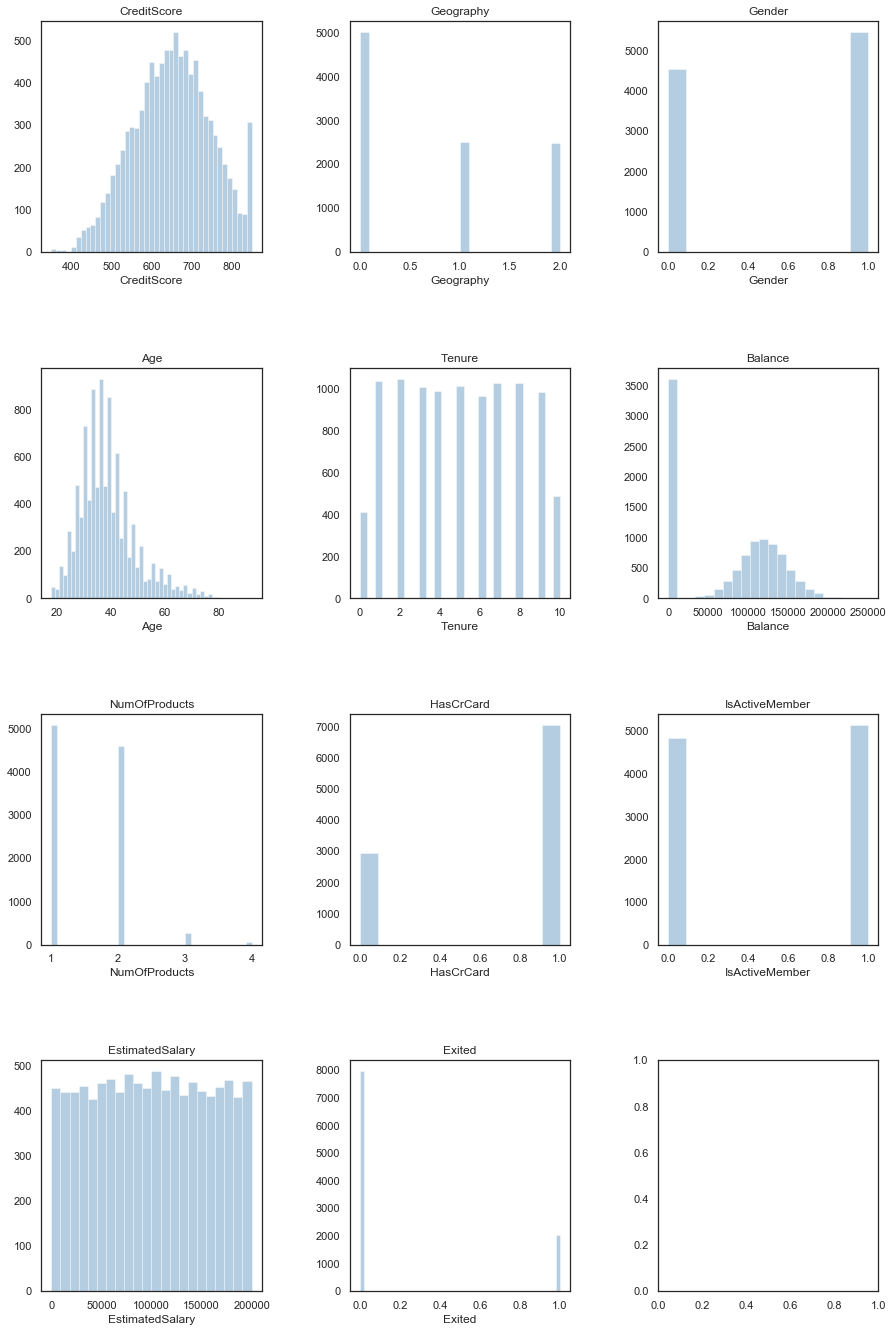

In [15]:
figure, axes = plt.subplots(4,3, figsize=(15,18))
for i in range(len(customers.columns)): 
    seaborn.distplot(a=customers[customers.columns[i]], ax = axes[i // 3][i % 3], color = "#4682b4", kde = False).set_title(customers.columns[i])
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
plt.show()

- La variable CreditScore a une distribution asymétrique à droite
- Les variables Gender et IsActiveMember, HasCrCard  et Exited sont binaires
- La variable Geography a trois modalités 
- La variable Age est asymétrique à gauche avec une traîne à droite
- La variable EstimatedSalary a une forte dispersion avec une répartition équitable 
- Les variables NumOfProducts et Tenure sont discrètes
- La variable balance semble être issu d'un mélange de lois

Les variables  présentent des intervalles Pour cette classification binaire une LDA aurait pu être envisagée mais cela supposerait d'avoir toutes les variables qui suivent une gaussienne ce qui n'est pas le cas.

#### Corrélations

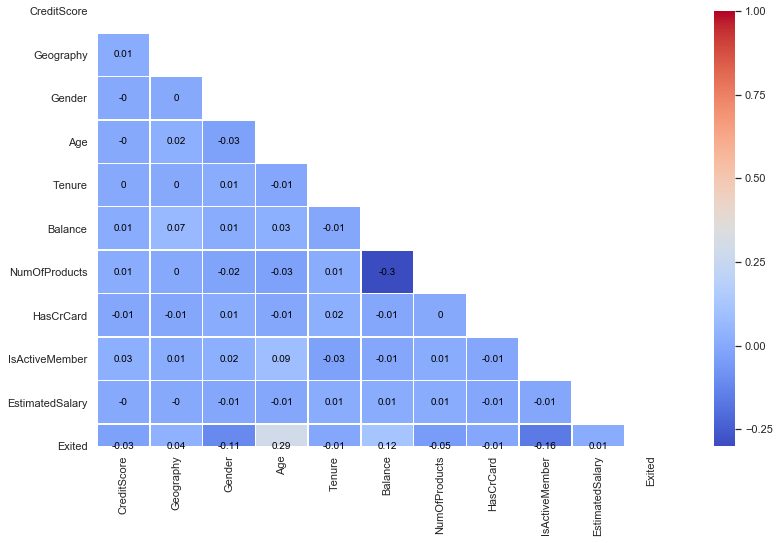

In [16]:
plt.figure(figsize = (13,8))
corr = numpy.round(customers.corr(),2) 
blank = numpy.zeros_like(corr)
blank[numpy.triu_indices_from(blank)] = True
with seaborn.axes_style("white"):
    ax = seaborn.heatmap(corr, mask=blank, annot=True, cmap="coolwarm", linewidths=.5, annot_kws={"color":"black"})
plt.show()

On observe que les corrélations entre les variables sont très faibles. 

<b>  Variable d'intérêt : Exited  </b>

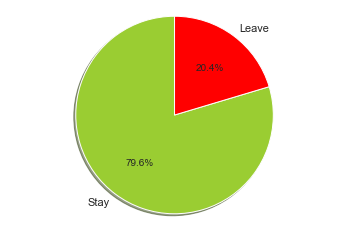

In [17]:
var_int = list(customers["Exited"])
leave = var_int.count(1)
stay = var_int.count(0)

labels = "Stay", "Leave", 
sizes = [stay, leave ]
colors = ["yellowgreen", "red"]

plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=90)
plt.axis("equal")
plt.show()

Au regard du diagramme, on peut dire qu'avec les modèles qu'on va construire,  on cherchera à avoir de bonnes prédictions.

## Applications des algorithmes d'apprentissage

Dans un premier temps il convient de séparer les données en train set et test set. Le nombre d'observations étant élevé, $20\%$ d'entre elles seront conservées en test.

In [18]:
X = customers.drop(columns=["Exited"])
Y = customers["Exited"]

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, shuffle=True, random_state=0)

### Évaluation de la performance du classifieur

Ensuite il va nous falloir des mesures pour évaluer la performance de nos classifieurs. On rappelle que la variable d'intérêt nous indique si chaque quitte ou non la banque. Le résultat pour chaque sujet peut ne pas correspondre à la réalité. Quatre résultats sont possible :

- Vrai Positif (VP) : Le client a vraiment quitté la banque et la banque est avertie de son départ 
- Faux Négatif (FN) : L'individu est encore client de la banque et la banque est avertie
- Faux Positif (FP) : Le client n'a pas quitté la banque mais la banque ne le reconnait plus 
- Vrai Négatif (VN) : Le client a quitté la banque mais la banque le reconnait toujours 

Ces quatres résultats peuvent être reformulés dans une courbe de contingence ou matrice de confusion. On observe cette matrice dans une fonction <code>viz_confusion_matrix</code>. 

On définit différents métriques pour mesurer la performancer d'un classifieur binaire :

- Accuracy (ACC) = (VP+VN)/(VN+FP+FN+VN)
- Precision (PPV) = VP/(VP+VN)
- Specificité (SPC) = VN/VN+FP
- Sensitivité (SEN) : SEN = VP/VP+FN
- F1 Score : Moyenne pondérée de la précision et de la spécificité est intéressant lorsqu'on a affaire à des données «déséquilibrées»

In [20]:
def viz_confusion_matrix(Y_pred):
    confmat = confusion_matrix(Y_test, Y_pred)
    df_confmat = pandas.DataFrame(confmat, index = (0, 1), columns = (0, 1))
    fig, ax = plt.subplots(figsize=(9, 6))
    seaborn.heatmap(df_confmat, annot=True, fmt='g', ax=ax)
    plt.show()

On peut aussi regarder la courbe ROC qui trace le Taux de Vrai Positif(TVP) en fonction du Taux de Faux Positif (TFP) qui sont donnés par :

$$\text{TVP} = \frac{\text{TVP}}{\text{TFP+TVP}} \ \ \ \ \ \text{TFP} = \frac{\text{TFP}}{\text{TFP+TVP}}$$

L'AUC correspond à l'air sous la courbe ROC. Les valeurs d'AUC sont comprises entre 0 à 1. Un modèle dont 100 % des prédictions sont erronées a un AUC de 0,0. Si toutes ses prédictions sont correctes, son AUC est de 1,0. La fonction <code>viz_roc_curve</code> permet de visualiser la courbe ROC pour un classifieur donné et la fonction <code>eval_perf</code> donne quelques indicateurs métriques.

In [21]:
def eval_perf(classifier, X_test, Y_test):
    Y_pred = classifier.predict(X_test)
    tfp, tvp, _ = roc_curve(Y_test.values, classifier.predict_proba(X_test)[:,1])
    dict_out = {
        "Precision" : precision_score(Y_test, Y_pred).round(3),
        "F1 Score" : f1_score(Y_test, Y_pred).round(3),
        "Accuracy" : accuracy_score(Y_test, Y_pred).round(3),
        'AUC': auc(tfp, tvp).round(3)
    }
    print("Métrique :", dict_out)

In [22]:
def viz_roc_curve(classifier, name, X_test, Y_pred):
    tfp, tvp, _ = roc_curve(Y_test.values, classifier.predict_proba(X_test)[:,1])
    auc_val = auc(tfp, tvp)
    fig, ax = plt.subplots(figsize=(8, 7))
    plt.title('Courbe ROC - ' + name)
    plt.plot(tfp, tvp)
    plt.plot([0, 1], ls = "--")
    plt.plot([0, 0], [1, 0] , c = ".7"), plt.plot([1, 1] , c = ".7")
    plt.ylabel("Taux de Vrai Positif")
    plt.xlabel("Taux de Faux Positif")
    plt.show()

### Régression logistique

La régression logisitique est une méthode de régression linéaire généralisée c'est-à-dire un modèle linéaire avec une fonction lien qui fait la liaison entre l'output de la régression linéaire multiple et la probabilité a priori de chaque classe $p(C_k|x) \in [0,1]$ utilisant la fonction sigmoid
$$p(C_k|w,_xi)=\frac{1}{1+\text{exp}(-w.x_i)}$$
Le but est de maximiser la fonction de coût $L$ 
$$min(L) = \Pi_{N}^{i}p(C_k|w,x_i)$$
avec $w$ vecteur poids et $x_i$ l'observation.

#### Le modèle

In [23]:
LogReg = LogisticRegression(class_weight = "balanced")

#### Sélection de variables

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [24]:
#Sélection des meilleures variables 
rfe = RFE(LogReg, n_features_to_select= None)
rfe = rfe.fit(X_train, Y_train)

#Sommaire des variables sélectionnées
print(rfe.support_)
print(rfe.ranking_)

# Train set avec sélection de variables
X_train_selectedvar = X_train.columns[rfe.support_]
X_train_selectedvar

[False  True  True  True False False  True False  True False]
[4 1 1 1 3 5 1 2 1 6]


Index(['Geography', 'Gender', 'Age', 'NumOfProducts', 'IsActiveMember'], dtype='object')

#### Fitting

In [25]:
LogReg.fit(X_train[X_train_selectedvar], Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Prédiction

In [26]:
Y_pred = LogReg.predict(X_test[X_train_selectedvar])

#### Performance

In [27]:
eval_perf(LogReg, X_test[X_train_selectedvar], Y_test)

Métrique : {'Precision': 0.367, 'F1 Score': 0.485, 'Accuracy': 0.692, 'AUC': 0.755}


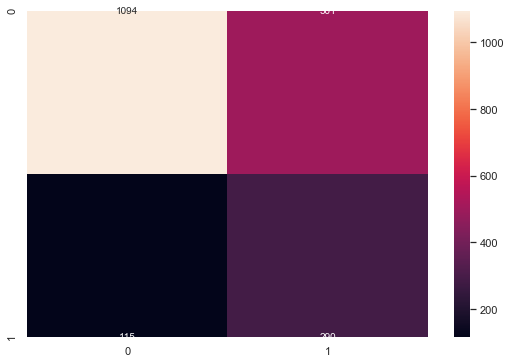

In [28]:
viz_confusion_matrix(Y_pred)

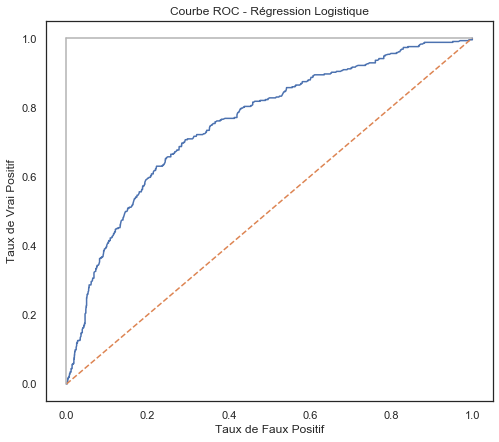

In [29]:
viz_roc_curve(LogReg, "Régression Logistique", X_test[X_train_selectedvar], Y_pred)

Les résultats obtenus sont satisfaisants : on obtient une aire sous la courbe ROC de 0.755 (rappelons qu'une aire égale à 0.5 revient à une prédiction aléatoire). On constate bien sur le graphique que la courbe ROC se détache de la première bissectrice. Par ailleurs, la matrice de transition nous indique qu'il y a plus vrais positifs que de faux positifs et plus de vrais négatifs que de faux négatifs : ce qui est cohérent avec les résultats observés précédemment.
Enfin, on obtient une accuracy 69.2% ce qui signifie que notre algorithme prédit le bon label pour 69.2% de notre base de test.

### K-Nearest Neighbors

Cette méthode nécessite de choisir une dissimilarité $\delta$ qui correspond à une mesure distance entre les individus. Ici, nous choisissons. À partir d'un nouvel indinvidi $e_{n+1}$, on calcule tous les $\delta(e_{n+1},e_i$) pour $1\le i \le n$.
- On regarde quels sont les cas plus proches voisins c'est-à-dire $\delta(e_{n+1}, e_{i1}) \le \delta(e_{n+1}, e_{i2}) \le ... \le \delta(e_{n+1}, e_{ik}) \le $ tous les autres $\delta(e_{n+1}, e_{i})$. 
- On attribue la classe majoritaire (0 ou 1) parmi les $Y_{i1},...,Y_{ik}$.

Tout d'abord nous implémentons une méthode dîte «naïve» qui consiste à choisir un nombre $K$ de proches voisins. 

#### Méthode naïve

<b> Le modèle </b>

Commençons par choisir de façon naïve un nombre de voisins égal à 5.

In [30]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<b> Prédiction </b>

In [31]:
Y_pred = KNN.predict(X_test)

<b> Performance </b>

In [32]:
eval_perf(KNN, X_test, Y_test)

Métrique : {'Precision': 0.291, 'F1 Score': 0.163, 'Accuracy': 0.764, 'AUC': 0.519}


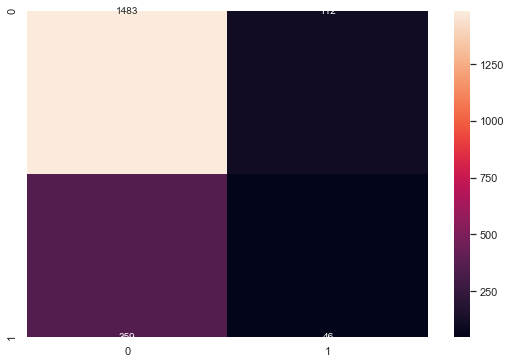

In [33]:
viz_confusion_matrix(Y_pred)

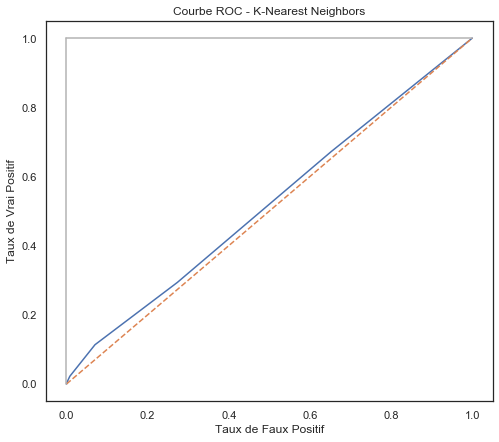

In [34]:
viz_roc_curve(KNN, "K-Nearest Neighbors", X_test, Y_pred)

Ensuite, nous implémentons une méthode où on détermine $K$ par validation croisée.

Les résultats obtenus ne sont pas satisfaisants : on obtient certes une accuracy relativement élevée 76.4%, néanmoins l'aire sous la courbe ROC est très faible : 0.519. Cela est dû au fait que notre algorithme prédit presque toujours la classe majoritaire (les clients qui restent). On le constate bien lorsqu'on observe la matrice de confusion. Ainsi, on obtient une accuracy élevée car la majorité de nos observations appartiennent à la classe '0', néanmoins notre algorithme n'est pas efficient car il prédit mal les clients qui vont quitter la banque.

#### Méthode par validation croisée

Pour chaque classifieur de paramètre $K$ 10 validation croisées sont réalisées.

In [35]:
k_range = list(range(1, 31)) # Intervalle de k
weight_opts = ["uniform", "distance"] # Option sur les poids
param_grid = dict(n_neighbors = k_range, weights = weight_opts)

cv_knn = GridSearchCV(KNN, param_grid, scoring="accuracy", cv=10)
cv_knn.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [36]:
print("Meilleur score : " + str(cv_knn.best_score_))
print("Paramètres optimaux : " + str(cv_knn.best_params_))

Meilleur score : 0.796125
Paramètres optimaux : {'n_neighbors': 24, 'weights': 'uniform'}


On utilise le meilleur paramètre pour faire de la prédiction :

In [37]:
KNN_opt = KNeighborsClassifier(n_neighbors=24, weights="uniform")

In [38]:
KNN_opt.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=24, p=2,
                     weights='uniform')

In [39]:
eval_perf(KNN_opt, X_test, Y_test)

Métrique : {'Precision': 0.2, 'F1 Score': 0.005, 'Accuracy': 0.796, 'AUC': 0.542}


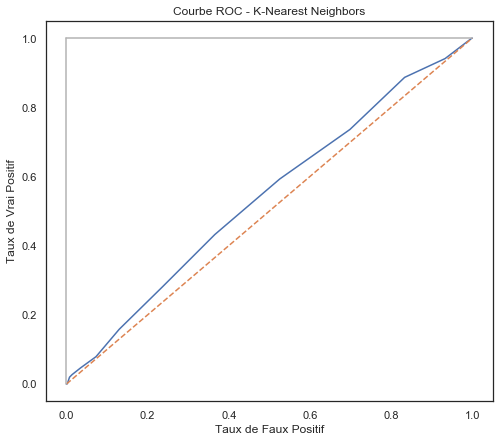

In [40]:
viz_roc_curve(KNN_opt, "K-Nearest Neighbors", X_test, Y_pred)

On a une amélioration de l'accuracy mais les résultats demeurent assez pauvre, une aire sous un peu plus élevée mais toujours aussi faible qui traduit un AUC de 0.54. Cet algorithme n'est pas adapté pour ce cas.

### Random Forest

#### Méthode Naïve

On peut commencer par fixer le nombre de classifieurs à 100 (paramètre n_estimators), choisir le critère de Gini (paramètre criterion) et la profondeur maximale des arbres à 10 (paramètre max_depth). On ajoute également le paramètre class_weight = "balanced".

#### Le modèle

In [41]:
RandomForest = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, n_jobs=-1, class_weight="balanced")

#### Fitting

In [42]:
RandomForest.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

#### Performance

In [43]:
eval_perf(RandomForest, X_test, Y_test)

Métrique : {'Precision': 0.579, 'F1 Score': 0.627, 'Accuracy': 0.836, 'AUC': 0.869}


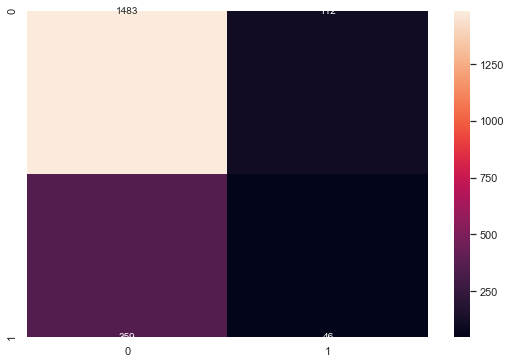

In [44]:
viz_confusion_matrix(Y_pred)

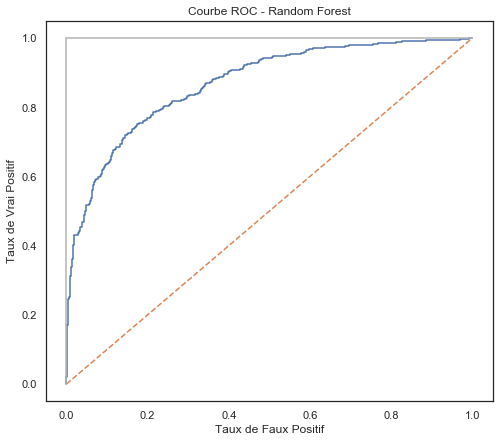

In [45]:
viz_roc_curve(RandomForest, "Random Forest", X_test, Y_pred)

On obtient de bons résultats : une aire sous la courbe ROC de 0.869 et une accuracy de 83.6%. Comme pour la regression logistique nous avons des résultats intéressants, néanmoins, l'algorithme de RandomForest nous fournit des meilleures performances parmi les trois pour l'instant.

#### Méthode par  validation croisée 

Les paramètres les plus importants pour le Random Forest sont :

- n_estimators : nombre d'arbres
- max_features : le nombre maximal de variables considérées pour découper un noeud
- max_depth : la profondeur de l'arbre
- min_samples_split : le nombre minimal de points placés dans un noeud avant de le découper
- min_samples_leaf : le nombre minimal de points autorisés dans une feuille <br>
- un booléen pour concernant l'application du bootstrap est une méthode de rééchantillonnage des observations.

In [46]:
param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}
RF_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RF_grid.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [47]:
RF_grid.best_params_

{'max_depth': 8,
 'max_features': 9,
 'min_samples_split': 5,
 'n_estimators': 100}

In [49]:
RF_opt = RandomForestClassifier(bootstrap=True, criterion='gini',max_depth=8, max_features=9, min_samples_split=5)

In [50]:
RF_opt.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

On a une 

In [51]:
eval_perf(RF_opt, X_test, Y_test)

Métrique : {'Precision': 0.718, 'F1 Score': 0.584, 'Accuracy': 0.858, 'AUC': 0.866}


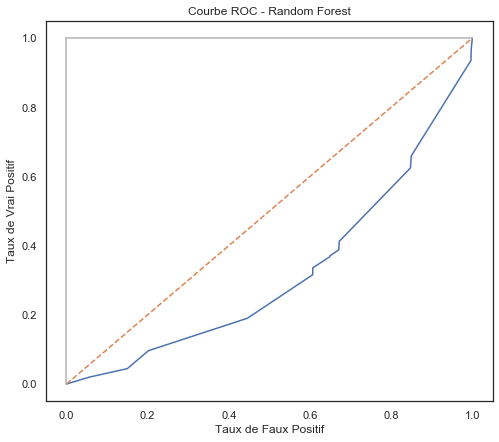

In [75]:
viz_roc_curve(RF_opt, "Random Forest", X_test, Y_pred)

Au niveau des métriques, on obtient de bons résultats avec des taux élevés. De plus, l'aire AUC est sous la courbe est de 0.86 avec un accuracy de 85.8%. Le Random Forest offre des résultats convaincants. Il n'est pas pourtant l'algorithme le plus simple à mettre en oeuvre. En effet, par son nombre élevé de paramètres il est difficile de tuner.

### Support Vector Machine

Les machines à vecteurs supports est un cas particulier du minimiseur du risque empirique convexifié. La fonction $\phi$ la plus couramment utilisée pour les SVM est la perte charnière *$\phi(x)=(1+x)_{+},$* mais toute autre $\phi$  peut également étre utilisée avec succès. La caractéristique principale des SVM porte non pas sur le choix de $\phi,$ mais sur le choix de l'ensemble $\mathcal{H}$ sur lequel se fait la minimisation du $\phi$ -risque. Dans le cas des SVM, $\mathcal{H}$ a la particularité d'être une boule dans un espace de Hilbert.

On peut définir le minimiseur du $\phi$ -risque empirique sur la boule de rayon $t>0$ dans l'espace $\mathcal{H}_{0} .$ Pour tout $t>0$ fixé, on définit alors le prédicteur

$$\widehat{h}{t} \in \arg \min _{h \in \mathcal{H}{0}:\|h\| \leq t} \frac{1}{n} \sum_{i=1}^{n} \phi\left(-Y_{i} h\left(X_{i}\right)\right) (*)$$


#### Méthode Naïve

In [ ]:

svc = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
## c-> Paramètre de régularisation 
## gamma -> coefficient du kernel pour  ‘rbf’, ‘poly’ et  ‘sigmoid’.


svc.fit(X_train, Y_train)


#### Performance

In [ ]:
eval_perf(svc, X_test, Y_test)

#### Méthode GridSearch

In [58]:
# On fait du tuning pour choisir les meilleurs paramètres de notre modèle
grid_search= GridSearchCV(estimator=svc, param_grid= { 'C': [0.01, 0.1, 1, 10, 100, 1000] , 'gamma': [ 1e-2, 1e-3, 1e-4] },
                          n_jobs=1, refit=True, scoring='roc_auc',verbose=0, cv=5, return_train_score=True)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3, gamma=0.1,
                           kernel='rbf', max_iter=-1, probability=True,
                           random_state=None, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [60]:
svc = SVC(kernel='rbf', probability=True, **grid_search.best_params_)
svc.fit(X_train, Y_train)
eval_perf(svc, X_test, Y_test)

Métrique : {'Precision': 0.0, 'F1 Score': 0.0, 'Accuracy': 0.797, 'AUC': 0.537}


### Réseaux de neurones Artificiels (ANN) 
Les réseaux de neurones sont réapparus comme des modèles de pointe dans de nombreuses applications de machine learning. L'un de leurs principaux avantages est qu'ils sont capables de capturer des informations dans les  données et de construire des modèles incroyablement complexes.
Si l'on dispose de suffisamment de temps de calcul, de données et d'un réglage minutieux des hyperparamètres, les modèles neuronaux surpassent souvent d'autres algorithmes machine learning pour la classification et la régression comme le random forest, le SVM...
 

In [16]:
# Feature Scaling : On fait cette méthode pour éviter que les valeurs abérrantes influencent un résultat. 
from sklearn.preprocessing import StandardScaler
simplefilter(action='ignore', category=FutureWarning)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Importation des modules de  keras
import keras
from keras.models import Sequential ##Initialiser le réseau de neurone
from keras.layers import Dense ## Créer les couches du résea de neurone
from keras.layers import Dropout ## pour éviter le sur-apprentissage


##Initialisation
ANN=Sequential ()

NameError: name 'X_train' is not defined

### Les 7 étapes pour entraîner un  réseau de neurones sont : 
**1 •** Initialiser les poids avec une valeurs proche de 0 mais different de 0

**2 •** Envoyer la premiere observation dans la couche d'entrée avec une variable par neurone

**3 •** Propagation avant 

**4 •** Comparer la valeur obtenue avec la vraie valeur de sortie et mesurer l'erreur avec la fonction cout

**5 •** Back propagation en remettant en jour les poids:$\;$  $w_{t+1}=w_{t}-\eta \frac{1}{\left|I_{t}\right|} \sum_{i \in I_{i}} \nabla_{w} \ell_{i}$

**6 •** Repeter etapes 1 à 5 et ajuster les poids après chauque observation

**7 •** Quand tout le jeu de donnees est passé à travers l'ANN, ca fait une époque . Refaire plus d'époque

In [70]:
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=FutureWarning)
##### Ajouter la couche d'entrée et la couche cachée
ANN.add(Dense(units=6, activation="relu", kernel_initializer="uniform",input_dim=10))
## units -> nombre de neurones qu'on va crééer sur la premère couche cachée : on a pris (nbre varaible d'entrée =10 + output=1) /2 == 6 
## activation-> c'est la fonction d'activation qu'on va appliquer à chaque neurone : ici redresseur  ="relu"
## Kernel_initializer -> initialisation des poids 
## input_dim -> nbre de couche d'entrée : ici on a  11 variables


##Pour éviter le overfitting :
ANN.add(Dropout(rate=0.1))
##rate-> nombre de neuron en moyenne qui vont etre desactivé : ici on de prendre 10% des neurons == chaque neurone  a 10% de chance d'être desactivé

## ajouter un deuxième couche cachée
ANN.add(Dense(units=6, activation="relu", kernel_initializer="uniform"))
ANN.add(Dropout(rate=0.1))

##Ajout de la couche de sortie 
ANN.add(Dense(units=1, activation="sigmoid", kernel_initializer="uniform"))

#Remarque : on pouvait augmenter le nombre de couche cachée de notre réseau , mais on choisit d'essayer avec deux couches cachées.

### ALgo gradient stochastique 
ANN.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
#binary_entropie  = log(1-e(sum wxi))

### Entrainer notre réseau de neurone 
ANN.fit(X_train, Y_train,batch_size=10,epochs=50)
## batz_size ->lot d'observation pour entraiener à chaque fois notre réseau ( on fait un apprentissage parlot ici )

Epoch 1/50
8000/8000 [==============================] - 4s 538us/step - loss: 0.5015 - acc: 0.7960
Epoch 2/50
8000/8000 [==============================] - 2s 303us/step - loss: 0.4442 - acc: 0.7960
Epoch 3/50
8000/8000 [==============================] - 2s 301us/step - loss: 0.4403 - acc: 0.7960
Epoch 4/50
8000/8000 [==============================] - 3s 325us/step - loss: 0.4408 - acc: 0.7960
Epoch 5/50
8000/8000 [==============================] - 3s 314us/step - loss: 0.4400 - acc: 0.7960
Epoch 6/50
8000/8000 [==============================] - 2s 296us/step - loss: 0.4357 - acc: 0.7960
Epoch 7/50
8000/8000 [==============================] - 2s 266us/step - loss: 0.4354 - acc: 0.7960
Epoch 8/50
8000/8000 [==============================] - 2s 301us/step - loss: 0.4359 - acc: 0.7960
Epoch 9/50
8000/8000 [==============================] - 2s 292us/step - loss: 0.4350 - acc: 0.7960
Epoch 10/50
8000/8000 [==============================] - 2s 286us/step - loss: 0.4354 - acc: 0.7960
Epoch 11/

In [72]:
### Partie 3 : prédictions

def eval_perf2(classifier, X_test, Y_test):
    Y_pred = classifier.predict(X_test)
    Y_pred=(Y_pred>0.5)
    
    
    #tfp, tvp, _ = roc_curve(Y_test, classifier.predict_proba(X_test)[:,1])
    dict_out = {
        "Precision" : precision_score(Y_test, Y_pred).round(3),
        "F1 Score" : f1_score(Y_test, Y_pred).round(3),
        "Accuracy" : accuracy_score(Y_test, Y_pred).round(3),
        #'AUC': auc(tfp, tvp).round(3)
    }
    print("Metrics :", dict_out)
eval_perf2(ANN, X_test, Y_test)


Metrics : {'Precision': 0.809, 'F1 Score': 0.346, 'Accuracy': 0.832}


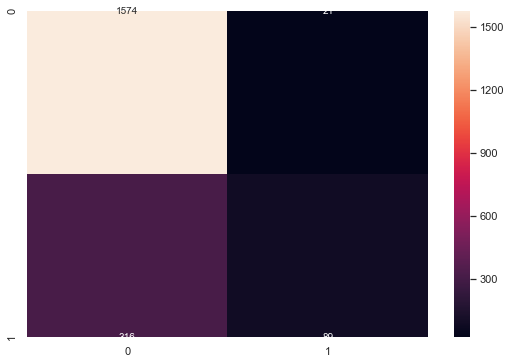

In [73]:
Y_pred = ANN.predict(X_test)
Y_pred=(Y_pred>0.5) ## Pour préciser notre threshold

viz_confusion_matrix(Y_pred) 

On a une précision de l'ordre de 83,2% , ce qui est acceptable et correcte. On va essayer d'augmenter cette précision en   optimisant certaines hyper-paramètres du modèles  : comme hyper-paramètres, on va seulement  prendre  le **batch_size**, les **epochs** , l'**optimizer** . 

In [19]:
### Optimisation des hyper-paramètres

##Choix des hyperparametres avec l'algo des gridsearch : qui permet de faire plusieurs combinaisons possibles d'hyper-parametres
## avant d'aboutir aux hyper-paramètres optimales.

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

##On va crééer notre classifieur
def build_classifieur (optimizer):
    classifieur=Sequential ()
    classifieur.add(Dense(units=6, activation="relu", kernel_initializer="uniform",input_dim=11))
    classifieur.add(Dense(units=6, activation="relu", kernel_initializer="uniform"))
    classifieur.add(Dense(units=1, activation="sigmoid", kernel_initializer="uniform"))
    classifieur.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])
    return classifieur

classifieur=KerasClassifier(build_fn=build_classifieur)

parameters={"batch_size":[25,32],
             "epochs":[100,500],
             "optimizer":["adam","rmsprop"]}

grid_search=GridSearchCV(estimator=classifieur,param_grid=parameters,scoring="accuracy",cv=10)
grid_search=grid_search.fit(X_train,Y_train) 


### Les meilleurs paramètres
best_param=grid_search.best_param_
best_precision=grid_search.best_score_ 

Using TensorFlow backend.


NameError: name 'X_train' is not defined

# Conclusion

L'algorithme de Random Forest parmi ceux utilisés est celui qui offre un résultat le plus convaincant. Néanmoins, on note aussi de bonnes performances par les réseaux de neurones artificiels. Il est donc possible de prédire avec ces algorithmes de manière efficace le désengagement de client. Cependant, le nombre de clients qui se désengage dans les données sont faibles. Les modèles pourrait être améliorés en les entraînant plusieurs fois et évaluer la stabilité de l'algorithme de choix qui donne de bonnes performances. 